Given a set of parameters (design optimised for coupling to a certain indx at a certain wavelength, i.e. $n_{eff} = 1.4$ at 1518.37 nm, how does the effective index vary based on variations to each of the design parameters?

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import time


#import autograd.numpy as npa
#from autograd import grad, value_and_grad

import legume
from legume import PlaneWaveExp, GuidedModeExp, Circle, ShapesLayer, Lattice, PhotCryst
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [2]:
def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters
    dx, dy, and dr, for the 2*Nx*Ny_opt number of pillars that get shifted
    """
    phc = PhotCryst(lattice, eps_l = 1, eps_u = 1)
    
    # Initialize a layer and the positions of the pillars for the regular waveguide
    phc.add_layer(d=d, eps_b=eps_b)
    
    xc = []; yc = []
    for ih in range(Ny):
        if ih != Ny//2:
            for ix in range(-Nx//2+1, Nx//2+1):
                xc.append((ih%2)*0.5 + ix)
                if ih <= Ny//2:
                    yc.append((-Ny//2 + ih + (1-W)/2)*np.sqrt(3)/2)
                else:
                    yc.append((-Ny//2 + ih - (1-W)/2)*np.sqrt(3)/2)

    # Add all the pillars, taking care of the shifts
    for ih in range(1, Ny//2+1):
        nx1 = (Ny//2+ih-1)
        nx2 = (Ny//2-ih)
        if ih <= Ny_opt:
            # The ih row includes "optimization" pillars
            for ix in range(Nx):
                circ = Circle(x_cent=xc[nx1*Nx + ix] + dx[(ih-1)*Nx + ix],
                              y_cent=yc[nx1*Nx + ix] + dy[(ih-1)*Nx  + ix],
                              r = ra + dr[(ih-1)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
                circ = Circle(x_cent=xc[nx2*Nx + ix] + dx[(ih-1+Ny_opt)*Nx  + ix],
                              y_cent=yc[nx2*Nx + ix] + dy[(ih-1+Ny_opt)*Nx  + ix],
                              r = ra + dr[(ih-1+Ny_opt)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
        else:
            # The ih row includes just regular pillars
            for ix in range(Nx):
                circ = Circle(x_cent = xc[nx2*Nx + ix], y_cent=yc[nx2*Nx + ix], r=ra, eps=eps_c)
                phc.add_shape(circ)
                if ih < Ny//2:
                    circ = Circle(x_cent = xc[nx1*Nx + ix], y_cent=yc[nx1*Nx + ix], r=ra, eps=eps_c)
                    phc.add_shape(circ)

    # Construct and return a plane-wave expansion object
    return phc

In [3]:
# PhC parameters
a = 420
ra = 0.5*256/a       # hole radius
eps_b = 3.453**2      # slab permittivity (n ~= 3.453 at low temp, n = 3.48 at room temp)
#eps_b = 11.7
eps_c = 1            # hole permittivity
d = 220/a          # slab thickness

W = 0.945

# plane-wave expansion parameters
gmax = 2     # truncation of the plane-wave basis
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the pillars will be modified
Nx = 1       # Supercell size in the x-direction

In [4]:
# Over Width
W_0 = W

Ws = np.arange(0.8, 1.2, 0.002) #+ 0.0003

cross_wvlns = []
n_effs = []

iteration = 0
total_it = len(Ws)

for i in np.arange(0,len(Ws)):
    W = Ws[i]

    # Initialize a rectangular lattice
    lattice = Lattice([Nx, 0], [0, (Ny-1+W)*np.sqrt(3)/2])

    # Initialize zero shifts
    dx0 = np.zeros((Nx*2*Ny_opt, ))
    dy0 = np.zeros((Nx*2*Ny_opt, ))
    dr0 = np.zeros((Nx*2*Ny_opt, ))

    # Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
    phc0 = wg_sc(dx0, dy0, dr0)

    nk = 50

    # Define a BZ path in kx
    path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
    #pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

    neig = 30

    # Initialize GME
    gme = legume.GuidedModeExp(phc0, gmax=gmax)

    # Set some of the running options
    options = {'gmode_inds': [0], 
               'numeig': neig,
               'verbose': False
                }

    # Run the simulation
    gme.run(kpoints=path['kpoints'], **options)

    f_ind = np.linspace(0, 1, neig)
    k = np.linspace(0, 0.5, nk+1)
    fv, kv = np.meshgrid(f_ind, k)
    # print(kv)
    n_eff = kv/gme.freqs
    wvln = a/gme.freqs

    ind = 14 # Index of mode in question

    n_target = 1.44
    n_diff = n_target - n_eff[:,ind]

    zero_crossings = np.where(np.diff(np.sign(n_diff)))
    cross_wvln = float(wvln[zero_crossings, ind])
    cross_wvlns = np.append(cross_wvlns, cross_wvln)
    
    wvln_target = 1518.37
    wvln_ind = wvln[:,ind]    #wvln for the mode in question
    n_eff_ind = n_eff[:,ind]  #n_eff for the mode in question
    
    sort = np.argsort(wvln_ind) # Sorting wvln monotonically
    
    wvln_sort = wvln_ind[sort]
    n_eff_sort = n_eff_ind[sort]
        
    tck = sc.interpolate.splrep(wvln_sort,n_eff_sort, s=0)
    n_eff_wvln = sc.interpolate.splev(wvln_target, tck, der=0) # Interpolate to find nee at wvln_target
    n_effs = np.append(n_effs, n_eff_wvln)
    
    iteration = iteration + 1
    print("Progress: " + str(iteration) + "/" + str(total_it) + "      ", end = "\r")
    
W = W_0
n_eff_w = n_effs

C:\Users\Toad\AppData\Local\Temp/ipykernel_23108/2000606686.py:50: RuntimeWarning: invalid value encountered in true_divide
  n_eff = kv/gme.freqs
C:\Users\Toad\AppData\Local\Temp/ipykernel_23108/2000606686.py:51: RuntimeWarning: divide by zero encountered in true_divide
  wvln = a/gme.freqs


(0.0, 3.0)

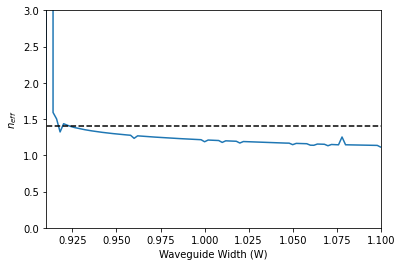

In [5]:
np.savetxt('Width_tolerace.dat', [Ws, n_eff_w])
#t = np.loadtxt('Width_tolerace.dat')
#plt.plot(t[0],t[1])

plt.plot(Ws, n_eff_w)
plt.plot([0.8,1.2],[1.4,1.4], 'k--') # Resonator neff
plt.plot([W,W], [1.4,1.4], 'k--') # Central Parameter
plt.xlabel("Waveguide Width (W)")
plt.ylabel("$n_{eff}$")
plt.xlim(0.91,1.1)
plt.ylim(0,3)

In [6]:
# Over Radius (Does variation in radius due to fabrication tolerances impact n_eff?)
r_0 = ra

ra_actual = np.arange(240,280,1) # Hole Diameter in nm
ra_s = ra_actual*0.5/a # Legume Units

cross_wvlns = []
n_effs = []

iteration = 0
total_it = len(ra_s)

for i in np.arange(0,len(ra_s)):
    ra = ra_s[i]

    # Initialize a rectangular lattice
    lattice = Lattice([Nx, 0], [0, (Ny-1+W)*np.sqrt(3)/2])

    # Initialize zero shifts
    dx0 = np.zeros((Nx*2*Ny_opt, ))
    dy0 = np.zeros((Nx*2*Ny_opt, ))
    dr0 = np.zeros((Nx*2*Ny_opt, ))

    # Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
    phc0 = wg_sc(dx0, dy0, dr0)

    nk = 50

    # Define a BZ path in kx
    path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
    #pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

    neig = 30

    # Initialize GME
    gme = legume.GuidedModeExp(phc0, gmax=gmax)

    # Set some of the running options
    options = {'gmode_inds': [0], 
               'numeig': neig,
               'verbose': False
                }

    # Run the simulation
    gme.run(kpoints=path['kpoints'], **options)

    f_ind = np.linspace(0, 1, neig)
    k = np.linspace(0, 0.5, nk+1)
    fv, kv = np.meshgrid(f_ind, k)
    # print(kv)
    n_eff = kv/gme.freqs
    wvln = a/gme.freqs

    ind = 15 # Index of mode in question

    n_target = 1.44
    n_diff = n_target - n_eff[:,ind]

    zero_crossings = np.where(np.diff(np.sign(n_diff)))
    cross_wvln = float(wvln[zero_crossings, ind])
    cross_wvlns = np.append(cross_wvlns, cross_wvln)
    
    wvln_target = 1518.37
    wvln_ind = wvln[:,ind]    #wvln for the mode in question
    n_eff_ind = n_eff[:,ind]  #n_eff for the mode in question
    
    sort = np.argsort(wvln_ind) # Sorting wvln monotonically
    
    wvln_sort = wvln_ind[sort]
    n_eff_sort = n_eff_ind[sort]
        
    tck = sc.interpolate.splrep(wvln_sort,n_eff_sort, s=0)
    n_eff_wvln = sc.interpolate.splev(wvln_target, tck, der=0) # Interpolate to find nee at wvln_target
    n_effs = np.append(n_effs, n_eff_wvln)
    
    iteration = iteration + 1
    print("Progress: " + str(iteration) + "/" + str(total_it) + "      ", end = "\r")
    
ra = r_0
n_eff_r = n_effs

(0.0, 3.0)

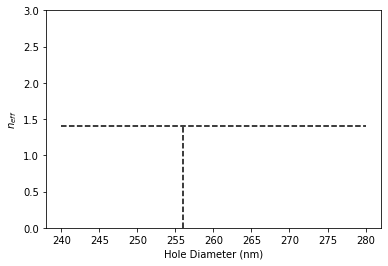

In [7]:
np.savetxt('Hole_tolerace.dat', [ra_actual, n_eff_r])
#t = np.loadtxt('Hole_tolerace.dat')
#plt.plot(t[0],t[1])

plt.plot(ra_actual, n_eff_r)
plt.plot([240,280],[1.4,1.4], 'k--') # Resonator neff
plt.plot([256,256],[0,1.4], 'k--') # Central Parameter
plt.xlabel("Hole Diameter (nm)")
plt.ylabel("$n_{eff}$")
#plt.xlim(0.91,1.1)
plt.ylim(0,3)

In [8]:
# Over thickness (Does variation in wafer thickness, including issues perhaps with the liftoff process effect n_eff?)
d_0 = d

d_actual = np.arange(215,230,0.1) # Hole Rad in nm
d_s = d_actual/a # Legume Units

cross_wvlns = []
n_effs = []

iteration = 0
total_it = len(d_s)

for i in np.arange(0,len(d_s)):
    d = d_s[i]

    # Initialize a rectangular lattice
    lattice = Lattice([Nx, 0], [0, (Ny-1+W)*np.sqrt(3)/2])

    # Initialize zero shifts
    dx0 = np.zeros((Nx*2*Ny_opt, ))
    dy0 = np.zeros((Nx*2*Ny_opt, ))
    dr0 = np.zeros((Nx*2*Ny_opt, ))

    # Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
    phc0 = wg_sc(dx0, dy0, dr0)

    nk = 50

    # Define a BZ path in kx
    path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
    #pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

    neig = 30

    # Initialize GME
    gme = legume.GuidedModeExp(phc0, gmax=gmax)

    # Set some of the running options
    options = {'gmode_inds': [0], 
               'numeig': neig,
               'verbose': False
                }

    # Run the simulation
    gme.run(kpoints=path['kpoints'], **options)

    f_ind = np.linspace(0, 1, neig)
    k = np.linspace(0, 0.5, nk+1)
    fv, kv = np.meshgrid(f_ind, k)
    # print(kv)
    n_eff = kv/gme.freqs
    wvln = a/gme.freqs

    ind = 14 # Index of mode in question

    n_target = 1.44
    n_diff = n_target - n_eff[:,ind]

    zero_crossings = np.where(np.diff(np.sign(n_diff)))
    cross_wvln = float(wvln[zero_crossings, ind])
    cross_wvlns = np.append(cross_wvlns, cross_wvln)
    
    wvln_target = 1518.37
    wvln_ind = wvln[:,ind]    #wvln for the mode in question
    n_eff_ind = n_eff[:,ind]  #n_eff for the mode in question
    
    sort = np.argsort(wvln_ind) # Sorting wvln monotonically
    
    wvln_sort = wvln_ind[sort]
    n_eff_sort = n_eff_ind[sort]
        
    tck = sc.interpolate.splrep(wvln_sort,n_eff_sort, s=0)
    n_eff_wvln = sc.interpolate.splev(wvln_target, tck, der=0) # Interpolate to find nee at wvln_target
    n_effs = np.append(n_effs, n_eff_wvln)
    
    iteration = iteration + 1
    print("Progress: " + str(iteration) + "/" + str(total_it) + "      ", end = "\r")
    
d = d_0
n_eff_d = n_effs

C:\Users\Toad\AppData\Local\Temp/ipykernel_23108/863003479.py:51: RuntimeWarning: invalid value encountered in true_divide
  n_eff = kv/gme.freqs
C:\Users\Toad\AppData\Local\Temp/ipykernel_23108/863003479.py:52: RuntimeWarning: divide by zero encountered in true_divide
  wvln = a/gme.freqs


(0.0, 3.0)

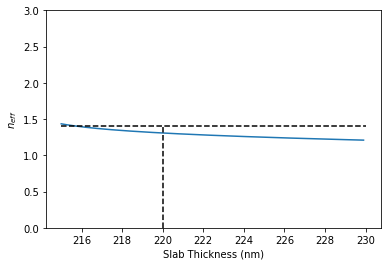

In [9]:
np.savetxt('Thickness_tolerace.dat', [d_actual, n_eff_d])
#t = np.loadtxt('Thickness_tolerace.dat')
#plt.plot(t[0],t[1])

plt.plot(d_actual, n_eff_d)
plt.plot([215,230],[1.4,1.4], 'k--') # Resonator neff
plt.plot([220,220],[0,1.4], 'k--') # Central Parameter
plt.xlabel("Slab Thickness (nm)")
plt.ylabel("$n_{eff}$")
#plt.xlim(0.91,1.1)
plt.ylim(0,3)

In [10]:
# How do variations on permitivity (i.e. due to temperature dependence) impact this?
eps_b_0 = eps_b

ns = np.arange(3.450,3.483,0.001) # Refractive index of silicon
eps_s = ns**2 # Permittivity of silicon

cross_wvlns = []
n_effs = []

iteration = 0
total_it = len(eps_s)

for i in np.arange(0,len(eps_s)):
    eps_b = eps_s[i]

    # Initialize a rectangular lattice
    lattice = Lattice([Nx, 0], [0, (Ny-1+W)*np.sqrt(3)/2])

    # Initialize zero shifts
    dx0 = np.zeros((Nx*2*Ny_opt, ))
    dy0 = np.zeros((Nx*2*Ny_opt, ))
    dr0 = np.zeros((Nx*2*Ny_opt, ))

    # Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
    phc0 = wg_sc(dx0, dy0, dr0)

    nk = 50

    # Define a BZ path in kx
    path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
    #pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

    neig = 30

    # Initialize GME
    gme = legume.GuidedModeExp(phc0, gmax=gmax)

    # Set some of the running options
    options = {'gmode_inds': [0], 
               'numeig': neig,
               'verbose': False
                }

    # Run the simulation
    gme.run(kpoints=path['kpoints'], **options)

    f_ind = np.linspace(0, 1, neig)
    k = np.linspace(0, 0.5, nk+1)
    fv, kv = np.meshgrid(f_ind, k)
    # print(kv)
    n_eff = kv/gme.freqs
    wvln = a/gme.freqs

    ind = 14 # Index of mode in question

    n_target = 1.44
    n_diff = n_target - n_eff[:,ind]

    zero_crossings = np.where(np.diff(np.sign(n_diff)))
    cross_wvln = float(wvln[zero_crossings, ind])
    cross_wvlns = np.append(cross_wvlns, cross_wvln)
    
    wvln_target = 1518.37
    wvln_ind = wvln[:,ind]    #wvln for the mode in question
    n_eff_ind = n_eff[:,ind]  #n_eff for the mode in question
    
    sort = np.argsort(wvln_ind) # Sorting wvln monotonically
    
    wvln_sort = wvln_ind[sort]
    n_eff_sort = n_eff_ind[sort]
        
    tck = sc.interpolate.splrep(wvln_sort,n_eff_sort, s=0)
    n_eff_wvln = sc.interpolate.splev(wvln_target, tck, der=0) # Interpolate to find nee at wvln_target
    n_effs = np.append(n_effs, n_eff_wvln)
    
    iteration = iteration + 1
    print("Progress: " + str(iteration) + "/" + str(total_it) + "      ", end = "\r")

eps_b = eps_b_0
n_eff_e = n_effs

C:\Users\Toad\AppData\Local\Temp/ipykernel_23108/3681670294.py:51: RuntimeWarning: invalid value encountered in true_divide
  n_eff = kv/gme.freqs
C:\Users\Toad\AppData\Local\Temp/ipykernel_23108/3681670294.py:52: RuntimeWarning: divide by zero encountered in true_divide
  wvln = a/gme.freqs


(0.0, 3.0)

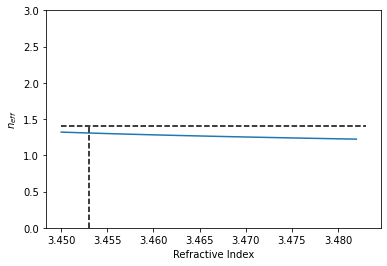

In [11]:
np.savetxt('Index_tolerace.dat', [ns, n_eff_e])
#t = np.loadtxt('Index_tolerace.dat')
#plt.plot(t[0],t[1])

plt.plot(ns, n_eff_e)
plt.plot([3.45,3.483],[1.4,1.4], 'k--') # Resonator neff
plt.plot([3.453,3.453],[0,1.4], 'k--') # Central Parameter
plt.xlabel("Refractive Index")
plt.ylabel("$n_{eff}$")
#plt.xlim(0.91,1.1)
plt.ylim(0,3)

In [12]:
# How do variations on lattice spacing
a_0 = a

a_s = np.arange(410,430,0.1) # Refractive index of silicon

cross_wvlns = []
n_effs = []

iteration = 0
total_it = len(a_s)

for i in np.arange(0,len(a_s)):
    a = a_s[i]
    ra = 0.5*256/a       # hole radius
    d = 220/a

    # Initialize a rectangular lattice
    lattice = Lattice([Nx, 0], [0, (Ny-1+W)*np.sqrt(3)/2])

    # Initialize zero shifts
    dx0 = np.zeros((Nx*2*Ny_opt, ))
    dy0 = np.zeros((Nx*2*Ny_opt, ))
    dr0 = np.zeros((Nx*2*Ny_opt, ))

    # Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
    phc0 = wg_sc(dx0, dy0, dr0)

    nk = 50

    # Define a BZ path in kx
    path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
    #pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

    neig = 30

    # Initialize GME
    gme = legume.GuidedModeExp(phc0, gmax=gmax)

    # Set some of the running options
    options = {'gmode_inds': [0], 
               'numeig': neig,
               'verbose': False
                }

    # Run the simulation
    gme.run(kpoints=path['kpoints'], **options)

    f_ind = np.linspace(0, 1, neig)
    k = np.linspace(0, 0.5, nk+1)
    fv, kv = np.meshgrid(f_ind, k)
    # print(kv)
    n_eff = kv/gme.freqs
    wvln = a/gme.freqs

    ind = 14 # Index of mode in question

    n_target = 1.44
    n_diff = n_target - n_eff[:,ind]

    zero_crossings = np.where(np.diff(np.sign(n_diff)))
    cross_wvln = float(wvln[zero_crossings, ind])
    cross_wvlns = np.append(cross_wvlns, cross_wvln)
    
    wvln_target = 1518.37
    wvln_ind = wvln[:,ind]    #wvln for the mode in question
    n_eff_ind = n_eff[:,ind]  #n_eff for the mode in question
    
    sort = np.argsort(wvln_ind) # Sorting wvln monotonically
    
    wvln_sort = wvln_ind[sort]
    n_eff_sort = n_eff_ind[sort]
        
    tck = sc.interpolate.splrep(wvln_sort,n_eff_sort, s=0)
    n_eff_wvln = sc.interpolate.splev(wvln_target, tck, der=0) # Interpolate to find nee at wvln_target
    n_effs = np.append(n_effs, n_eff_wvln)
    
    iteration = iteration + 1
    print("Progress: " + str(iteration) + "/" + str(total_it) + "      ", end = "\r")

a = a_0
d = d_0
ra = r_0

n_eff_a = n_effs

(0.0, 3.0)

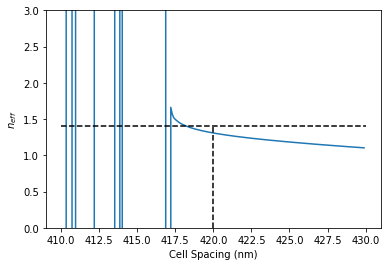

In [13]:
np.savetxt('Spacing_tolerace.dat', [a_s, n_eff_a])
#t = np.loadtxt('Spacing_tolerace.dat')
#plt.plot(t[0],t[1])
plt.plot(a_s, n_eff_a)
plt.plot([410,430],[1.4,1.4], 'k--') # Resonator neff
plt.plot([420,420],[0,1.4], 'k--') # Central Parameter
plt.xlabel("Cell Spacing (nm)")
plt.ylabel("$n_{eff}$")
#plt.xlim(0.91,1.1)
plt.ylim(0,3)